# Github PR Analysis

**Merge-timeline vs. (Lines of Code | Files Changed)**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following issue metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

In [1]:
import psycopg2
import numpy as np
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = (15, 5)
import warnings
warnings.filterwarnings('ignore')

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440]


# Files and Lines of Code changed per PR

How does a project handle contributions? In the open source model, changes to a code base are suggested in the form of Pull Requests which are composed of one or more commits made by one or more authors. They become a part of one or more branches of the project when they are 'merged,' and until this time they remain 'open.' In some cases, the suggested changes can be discarded for any number of reasons and in this situation the pull request is considered 'closed.' 

We would like to analyze the PR time-to-merge and PR time-to-close behavior of a project and try to make some generalizations about this behavior. Successful projects may enforce some constraints that, if followed, dramatically increase the probability of a PR being 'merged' rather than 'closed.' 

(A PR being 'closed' does not necessarily mean that the suggested changes were discarded. They could have been broken up into separate PR's and incorporated later. However, this distinction is important to analyze because those PR's that were 'closed' could represent those PR's that don't fit the standards of the project and are important to understand.)

We will begin by visualizing this information in the hope of extracting some useful visual heuristics about these categories of PR. From there, we will go into Survival Analysis, hoping to observe trends in the project including probablistic merge behavior (e.g. there is an 80% chance that a PR of 'x' size will be merged in 'y' time).

**Below:**

Get all PR's (including those files that were in the PR) associated with a specified repository.

In [4]:
df_pr_files = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
					pr.pull_request_id AS pr_id,
                    prf.pr_file_id as file_id,
                    prf.pr_file_additions as additions,
                    prf.pr_file_deletions as deletions,
                    prf.pr_file_additions + prf.pr_file_deletions as total_changes,
                    pr.pr_created_at as created,
                    pr.pr_merged_at as merged,
                    pr.pr_closed_at as closed
                    
                FROM
                	repo r,
                    pull_requests pr,
                    pull_request_files prf

                WHERE
                	r.repo_id = pr.repo_id AND
                    r.repo_id = \'{repo_id}\' AND
                    prf.pull_request_id = pr.pull_request_id
                ORDER BY
                    pr_id
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr_files = pd.concat([df_pr_files, df_current_repo])

df_pr_files = df_pr_files.reset_index()
df_pr_files.drop("index", axis=1, inplace=True)
        
df_pr_files.head(5)

,pr_id,file_id,additions,deletions,total_changes,created,merged,closed
0,210007,46811,86,3,89,2017-01-23 18:50:08,2017-01-23 20:49:42,2017-01-23 20:49:42
1,210008,46606,2,0,2,2017-01-31 17:08:16,2017-01-31 20:09:52,2017-01-31 20:09:52
2,210009,53814,2,0,2,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19
3,210009,53813,2,0,2,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19
4,210009,106809,5,1,6,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19


## Which PRs were closed without being merged?

In [5]:
"""
These are the PRs that were closed without being merged.
"""
df_pr_closed = df_pr_files[df_pr_files['merged'].isna() & df_pr_files['closed'].notna()]
df_pr_closed['close_window'] = df_pr_closed['closed'] - df_pr_closed['created']
df_pr_closed['close_window'] = df_pr_closed['close_window'].apply(lambda d: d.days + 1)
df_pr_closed.head()

,pr_id,file_id,additions,deletions,total_changes,created,merged,closed,close_window
5,210010,39274,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1
6,210010,39275,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1
7,210010,39273,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1
8,210010,39272,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1
9,210010,39276,3,1,4,2017-02-01 20:39:53,NaT,2017-02-02 16:50:19,1


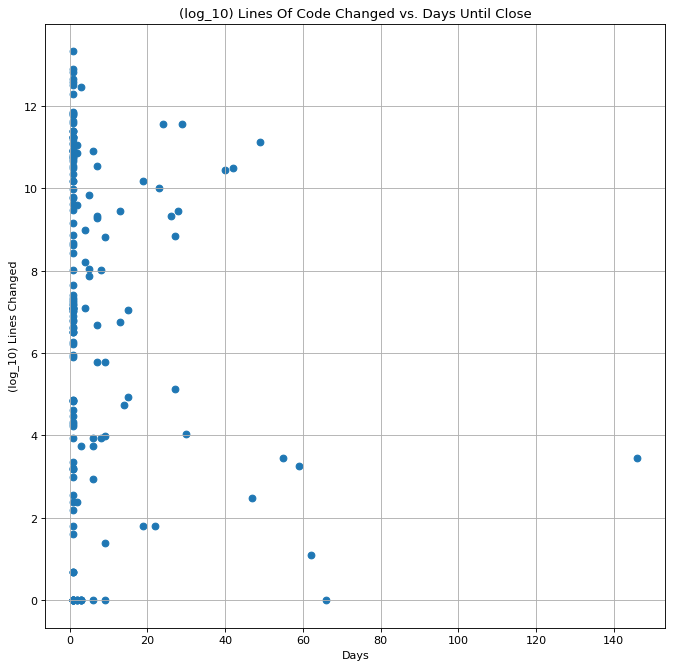

In [6]:
# map the total number of lines changed per PR
df_pr_closed_fc = df_pr_closed.assign(sumChanges = df_pr_closed['pr_id'].map(df_pr_closed.groupby('pr_id')['total_changes'].sum()))

# drop any extra columns so we just see the PR, the days required to merge, and the number of changes made across all files.
df_pr_closed_fc = df_pr_closed_fc.drop(['file_id', 'additions', 'deletions', 'total_changes', 'created', 'merged', 'closed'], axis=1).drop_duplicates('pr_id')

# plot
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_pr_closed_fc['close_window'], np.log(df_pr_closed_fc['sumChanges']))
plt.grid(True)
plt.title("(log_10) Lines Of Code Changed vs. Days Until Close")
plt.xlabel("Days")
plt.ylabel("(log_10) Lines Changed")
plt.show()

## Which PRs are still open and how long have they been open?

In [7]:
"""
These are the PRs that have yet to be merged or closed (are still open).
"""
df_pr_open = df_pr_files[df_pr_files['merged'].isna() & df_pr_files['closed'].isna()]
df_pr_open['open_window'] = datetime.now() - df_pr_open['created']
df_pr_open['open_window'] = df_pr_open['open_window'].apply(lambda d: d.days + 1)
df_pr_open.head()

,pr_id,file_id,additions,deletions,total_changes,created,merged,closed,open_window
42296,213921,68594,3,3,6,2020-09-11 00:00:48,NaT,NaT,401
43402,214020,70400,1,0,1,2020-10-12 19:20:28,NaT,NaT,369
43403,214020,70401,1,0,1,2020-10-12 19:20:28,NaT,NaT,369
43404,214020,100242,11,1,12,2020-10-12 19:20:28,NaT,NaT,369
43406,214022,161176,66,58,124,2020-10-14 09:15:54,NaT,NaT,368


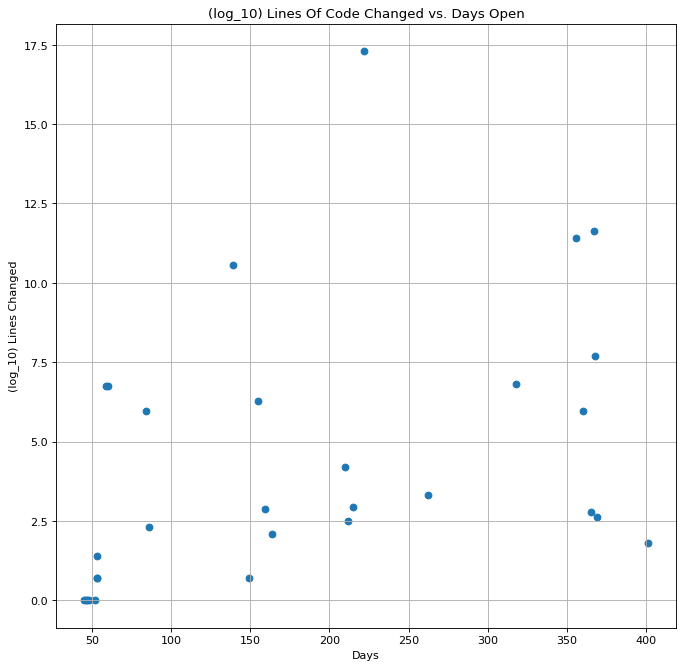

In [8]:
# map the total number of lines changed per PR
df_pr_open_fc = df_pr_open.assign(sumChanges = df_pr_open['pr_id'].map(df_pr_open.groupby('pr_id')['total_changes'].sum()))

# drop any extra columns so we just see the PR, the days required to merge, and the number of changes made across all files.
df_pr_open_fc = df_pr_open_fc.drop(['file_id', 'additions', 'deletions', 'total_changes', 'created', 'merged', 'closed'], axis=1).drop_duplicates('pr_id')

# plot
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_pr_open_fc['open_window'], np.log(df_pr_open_fc['sumChanges']))
plt.grid(True)
plt.title("(log_10) Lines Of Code Changed vs. Days Open")
plt.xlabel("Days")
plt.ylabel("(log_10) Lines Changed")
plt.show()

## Which PRs have been merged and closed?

In [9]:
"""
These are the PRs that have been merged and closed.
"""
df_pr_merged = df_pr_files[df_pr_files['merged'].notna()]
df_pr_merged['merge_window'] = df_pr_merged['merged'] - df_pr_merged['created']
df_pr_merged['merge_window'] = df_pr_merged['merge_window'].apply(lambda d: d.days + 1)
df_pr_merged.head(5)

,pr_id,file_id,additions,deletions,total_changes,created,merged,closed,merge_window
0,210007,46811,86,3,89,2017-01-23 18:50:08,2017-01-23 20:49:42,2017-01-23 20:49:42,1
1,210008,46606,2,0,2,2017-01-31 17:08:16,2017-01-31 20:09:52,2017-01-31 20:09:52,1
2,210009,53814,2,0,2,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19,1
3,210009,53813,2,0,2,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19,1
4,210009,106809,5,1,6,2017-02-01 20:33:36,2017-02-02 16:52:19,2017-02-02 16:52:19,1


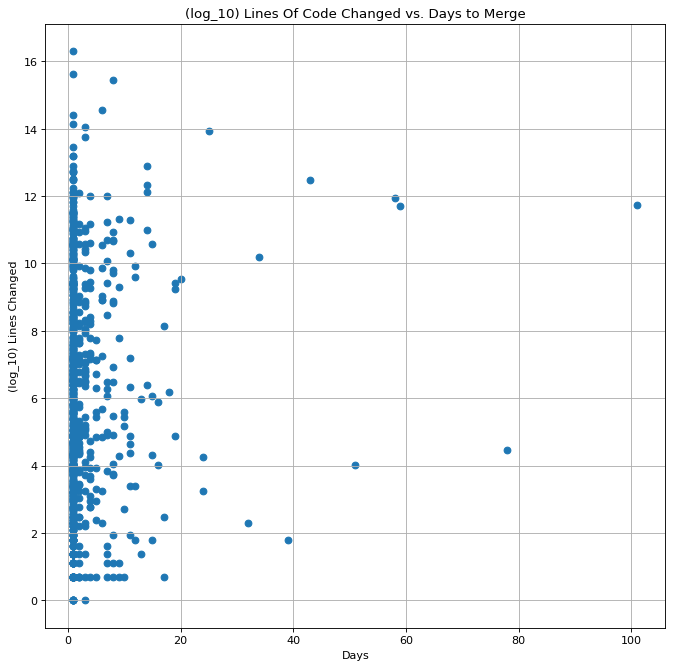

In [10]:
# map the total number of lines changed per PR
df_pr_merged_fc = df_pr_merged.assign(sumChanges = df_pr_merged['pr_id'].map(df_pr_merged.groupby('pr_id')['total_changes'].sum()))

# drop any extra columns so we just see the PR, the days required to merge, and the number of changes made across all files.
df_pr_merged_fc = df_pr_merged_fc.drop(['file_id', 'additions', 'deletions', 'total_changes', 'created', 'merged', 'closed'], axis=1).drop_duplicates('pr_id')

# plot
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_pr_merged_fc['merge_window'], np.log(df_pr_merged_fc['sumChanges']))
plt.grid(True)
plt.title("(log_10) Lines Of Code Changed vs. Days to Merge")
plt.xlabel("Days")
plt.ylabel("(log_10) Lines Changed")
plt.show()

## Does # of lines changed correlate visually with time-to-merge (and/or) merge-status?

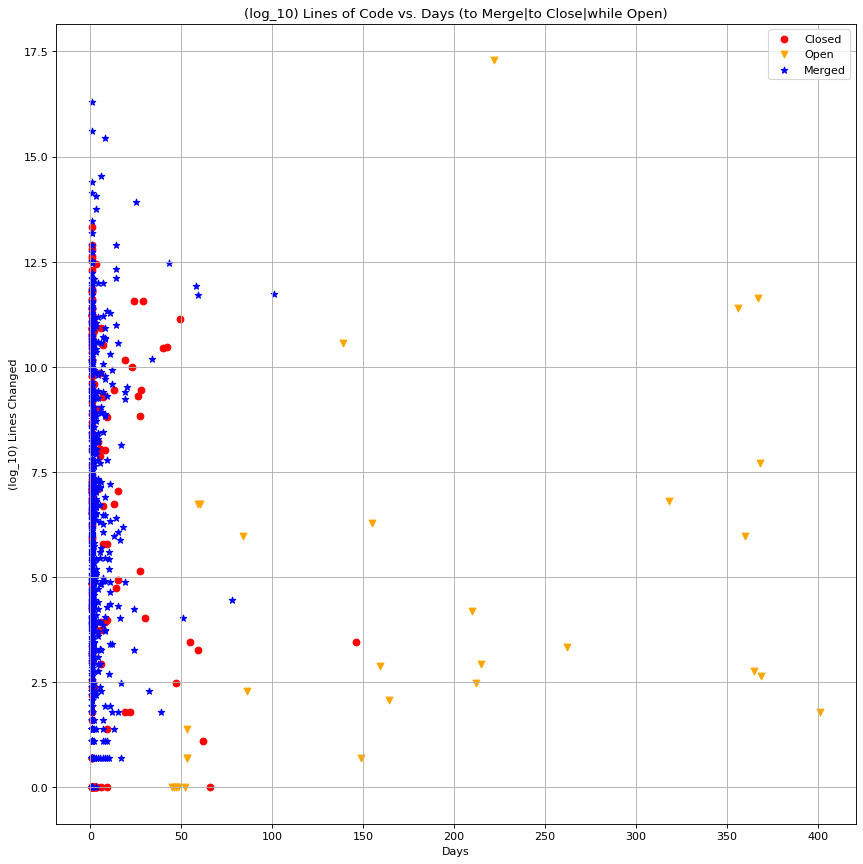

In [11]:
fig = plt.figure( figsize=(10,10), dpi=80 )
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Days")
ax.set_ylabel("(log_10) Lines Changed")
ax.set_title("(log_10) Lines of Code vs. Days (to Merge|to Close|while Open)")
ax.grid(True)
ax.scatter( df_pr_closed_fc['close_window'], np.log(df_pr_closed_fc['sumChanges']), color='red', marker='o', label="Closed")
ax.scatter( df_pr_open_fc['open_window'], np.log(df_pr_open_fc['sumChanges']), color='orange', marker='v', label="Open")
ax.scatter( df_pr_merged_fc['merge_window'], np.log(df_pr_merged_fc['sumChanges']), color='blue', marker='*', label="Merged")
ax.legend(["Closed", "Open", "Merged"])

There are some pretty dramatic visual outliers among those PRs that have yet to be merged leading to a pretty sparse plot. We ought to replot the data with some limits on the ranges.


Visually, an overlay of the populations doesn't seem to have very strong correlation. It may be more advantageous to look at the populations statistically. 

The next step is to try to do some survival analysis using the LifeLines module. We can include all of the populations but if we include the open issues, we need to 

In [12]:
# what is the probability of a PR still being open after 'n' time?
# we have data points regarding those PR's that have 'died' which are those that were merged or closed.
# and we have the censored group which are those that are still open. Is it statistically valid to 
# make a population out of those who PR's that were closed <union> those that were merged? I don't think so.
# For the moment I think that I can get away with homogenizing them but in the future I think that there needs 
# to be more analysis of this.

In [13]:
from lifelines import KaplanMeierFitter

In [28]:
"""
    Need durations of all PR's as a column.
    This is just a total time bin up to today. 
    If a PR is still open we keep duration BUT we
    also park it as having been censored.
"""
closed_dur = df_pr_closed_fc['close_window'].to_numpy()
merged_dur = df_pr_merged_fc['merge_window'].to_numpy()
open_dur = df_pr_open_fc['open_window'].to_numpy()

total_durs = np.concatenate((np.concatenate((closed_dur, merged_dur)), open_dur))
print(total_durs)

censorship = np.ones( len(total_durs) )
censorship[len(closed_dur) + len(merged_dur): ] = 0

[ 1  6  1 ... 47 46 45]


Text(0, 0.5, 'Probability of Close')

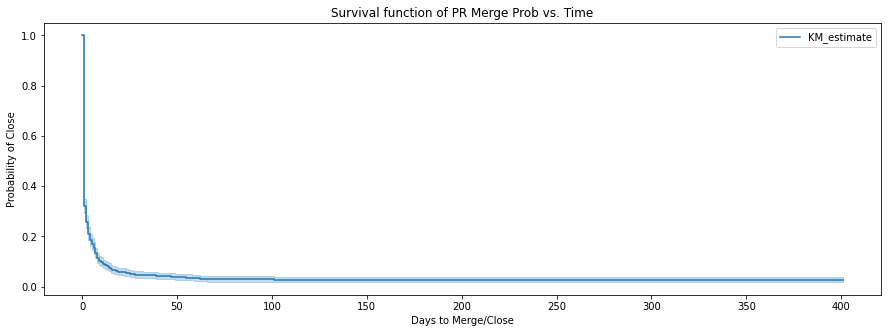

In [30]:
kmf = KaplanMeierFitter()
T = total_durs
C = censorship
kmf.fit(T, C)
kmf.plot()
plt.title('Survival function of PR Merge Prob vs. Time')
plt.xlabel("Days to Merge/Close")
plt.ylabel("Probability of Close")

Text(0, 0.5, 'Probability of Close')

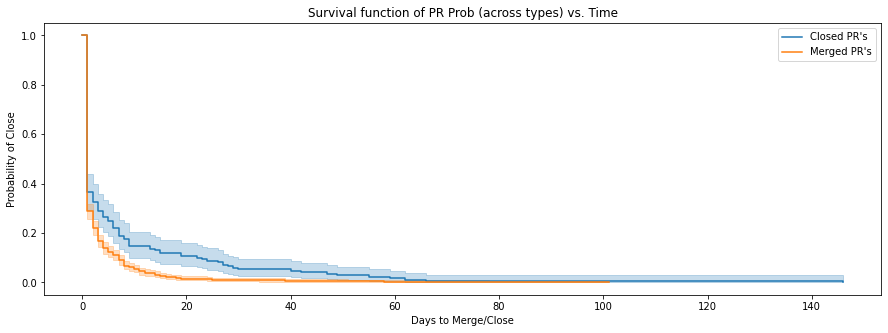

In [36]:
# we don't have censored data here. I honestly don't know how to combine these because merged and closed are different population and we don't know which population 'open' will resolve to be.
kmf2 = KaplanMeierFitter()
kmf2.fit(closed_dur, np.ones(len(closed_dur)), label="Closed PR's")
ax = kmf2.plot()
kmf2.fit(merged_dur, np.ones(len(merged_dur)), label="Merged PR's")
ax = kmf2.plot(ax=ax)
plt.title("Survival function of PR Prob (across types) vs. Time")
plt.xlabel("Days to Merge/Close")
plt.ylabel("Probability of Close")